**This file is built on 13. June by Group 2** <br/>
Group Members:


*   Henri Garcia-pelayo
*   Haozhe Tang
*   Ines Cerne
*   Yuanyuan Liu



In [1]:
pip install kaggle

### Imports

In [2]:
# import libraries
#Normal library
from IPython.display import Image, display
import numpy as np
import os
from os.path import join
from PIL import ImageFile
import pandas as pd
from matplotlib import cm
import seaborn as sns
import matplotlib.pyplot as plt
import zipfile
import re
import glob
import cv2

#Sklearn
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import classification_report

#Tensorflow
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Conv2D,
                                     MaxPooling2D,
                                     Dense,
                                     Flatten,
                                    Dropout,
                                    BatchNormalization)
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import load_img



In [3]:
# Kaggle API settings
import json
token = {"username":"skyemalfoy","key":"1046f989c83a08dbd6c0070f849ffc1b"}
with open('/content/kaggle.json', 'w') as file:
  json.dump(token, file)

!mkdir -p ~/.kaggle
!cp /content/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle config set -n path -v /content
!kaggle competitions download -c dogs-vs-cats

- path is now set to: /content
dogs-vs-cats.zip: Skipping, found more recently modified local copy (use --force to force download)


# 1. Data importing and discovery


In [4]:
#Extract zip file:
zip_files = glob.glob('/content/competitions/dogs-vs-cats/dogs-vs-cats.zip')

for file in zip_files:
  with zipfile.ZipFile(file, 'r') as Z:
    Z.extractall('data_all')

train_file = glob.glob('/content/data_all/train.zip')

for file in train_file:
  with zipfile.ZipFile(file, 'r') as Z:
    Z.extractall('train')

In [5]:
filepath = "/content/train/train"
filenames = os.listdir("/content/train/train")
#Create lists for storing categories of image and image array.
categories = []
images = []
for filename in filenames:
  #Split the name of images by the symbol ".", select the first element as the category.
    category = filename.split('.')[0]
    #Map the category of the images with 0 and 1. 1: dog image, 0: not dog(cat) image
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)
    img_array = cv2.imread(os.path.join(filepath, filename)) # No grayscale conversion
    img_array = cv2.resize(img_array, dsize=(224, 224)) # Resizing to 224x224
    images.append(img_array)

In [6]:
len(images)

25000

# 2. Data preprocessing

## 2.1 Data Splitting
<li>70% for training</li>
<li>20% for testing</li>
<li>10% for validation</li>

**Considering the limited coding environment, it is impossible to use all <a >25,000 images</a> for this work. Instead, we only use <a>5,000 of images</a> as the whole dataset.**

In [7]:
X = np.array(images[:5000])
y = np.array(categories[:5000])
X_train, X_test, y_train, y_test = train_test_split(X,y,
                                                    stratify=y,
                                                    test_size=0.3,
                                                    random_state=42)

X_val, X_test, y_val, y_test, = train_test_split(X_test,
                                                 y_test,
                                                  stratify=y_test,
                                                  test_size=2/3,
                                                  random_state=42)
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(3500, 224, 224, 3)
(1000, 224, 224, 3)
(500, 224, 224, 3)


#3.Model Building and application

In [8]:
#Function to draw learning curve.
def lr_graph(history):
  epoch = range(len(history.history['loss']))
  fig, axs = plt.subplots(1,2,figsize=(10,5), dpi=800)

  for ax in axs.ravel():
      #Loss plot
      sns.lineplot(x= epoch, y = history.history['loss'], ax = axs[0], linewidth=4, color='red')
      sns.lineplot(x=epoch, y = history.history['val_loss'], ax = axs[0], linewidth=4, color='blue')
      axs[0].set_title('Loss learning rate', fontsize=20)
      axs[0].set_xlabel('Epoch', fontsize=15)
      axs[0].set_ylabel('Loss', fontsize=15)
      axs[0].legend(loc='best', fontsize=15)

      #Accuracy plot
      sns.lineplot(x=epoch, y = history.history['accuracy'], ax = axs[1], linewidth=4,color='red')
      sns.lineplot(x=epoch, y = history.history['val_accuracy'], ax = axs[1], linewidth=4, color='blue')
      axs[1].set_title('Accuracy learning rate', fontsize=20)
      axs[1].set_xlabel('Epoch', fontsize=15)
      axs[1].set_ylabel('Loss', fontsize=15)
      axs[1].legend(loc='best', fontsize=15)

  plt.show()

##3.1 CNN model

### 3.1.1 Model building

In [9]:
# Initialize a linear stack of layers. Then add hidden layers and outputs.
CNN_model = Sequential([
    #Layer1
    #Because Images have height and width, so we choose Conv2D to realise 2-dimensional convolution. Also for maxpooling function.
    Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(224, 224, 3)),
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
    # Batch normalization applies a transformation that maintains the mean output close to 0 and the output standard deviation close to 1.
    BatchNormalization(),
    #Apply dropout to avoid overfitting.
    Dropout(.25),

    #Layer2
    Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(224, 224, 3)),
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
    BatchNormalization(),
    Dropout(.25),

    #Layer3
    Conv2D(128, (3, 3), activation='relu', padding='same', input_shape=(224, 224, 3)),
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
    BatchNormalization(),
    Dropout(.25),

    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='sigmoid') # A binary classification
])


In [10]:
CNN_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 32)     0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 112, 112, 32)     128       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 112, 112, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 64)       0

In [11]:
#Set callbacks
# Early stop
earlystop = EarlyStopping(patience=10) #Prevent over fitting.

#Learning Rate Reduction
lrr = ReduceLROnPlateau(monitor='val_accuracy',
                        patience=2,
                        verbose=1,
                        factor=0.5,
                        min_lr=1e-5)
callbacks = [earlystop, lrr]

### 3.1.2 Model training and fitting

In [12]:
loss = 'sparse_categorical_crossentropy'
#Learning rate is changing according to the performance of the model.
optimizer = Adam(learning_rate=1e-3)
metrics = ['accuracy']
batch_size = 16

CNN_model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

CNN_history = CNN_model.fit(X_train,
                          y_train,
                          epochs=10,
                          batch_size=batch_size,
                          validation_data=(X_val, y_val),
                          callbacks=callbacks
                          )

Epoch 1/10
219/219 [==============================] - 27s 64ms/step - loss: 5.5353 - accuracy: 0.5554 - val_loss: 0.7552 - val_accuracy: 0.5720 - lr: 0.0010
Epoch 2/10
219/219 [==============================] - 13s 61ms/step - loss: 0.6761 - accuracy: 0.5980 - val_loss: 0.6320 - val_accuracy: 0.6380 - lr: 0.0010
Epoch 3/10
219/219 [==============================] - 13s 61ms/step - loss: 0.6728 - accuracy: 0.5817 - val_loss: 0.6566 - val_accuracy: 0.6040 - lr: 0.0010
Epoch 4/10
218/219 [============================>.] - ETA: 0s - loss: 0.6740 - accuracy: 0.5631
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
219/219 [==============================] - 13s 61ms/step - loss: 0.6739 - accuracy: 0.5623 - val_loss: 0.6592 - val_accuracy: 0.5740 - lr: 0.0010
Epoch 5/10
219/219 [==============================] - 13s 62ms/step - loss: 0.6422 - accuracy: 0.5997 - val_loss: 0.6247 - val_accuracy: 0.6120 - lr: 5.0000e-04
Epoch 6/10
218/219 [============================>.

### 3.1.3 Learning curve

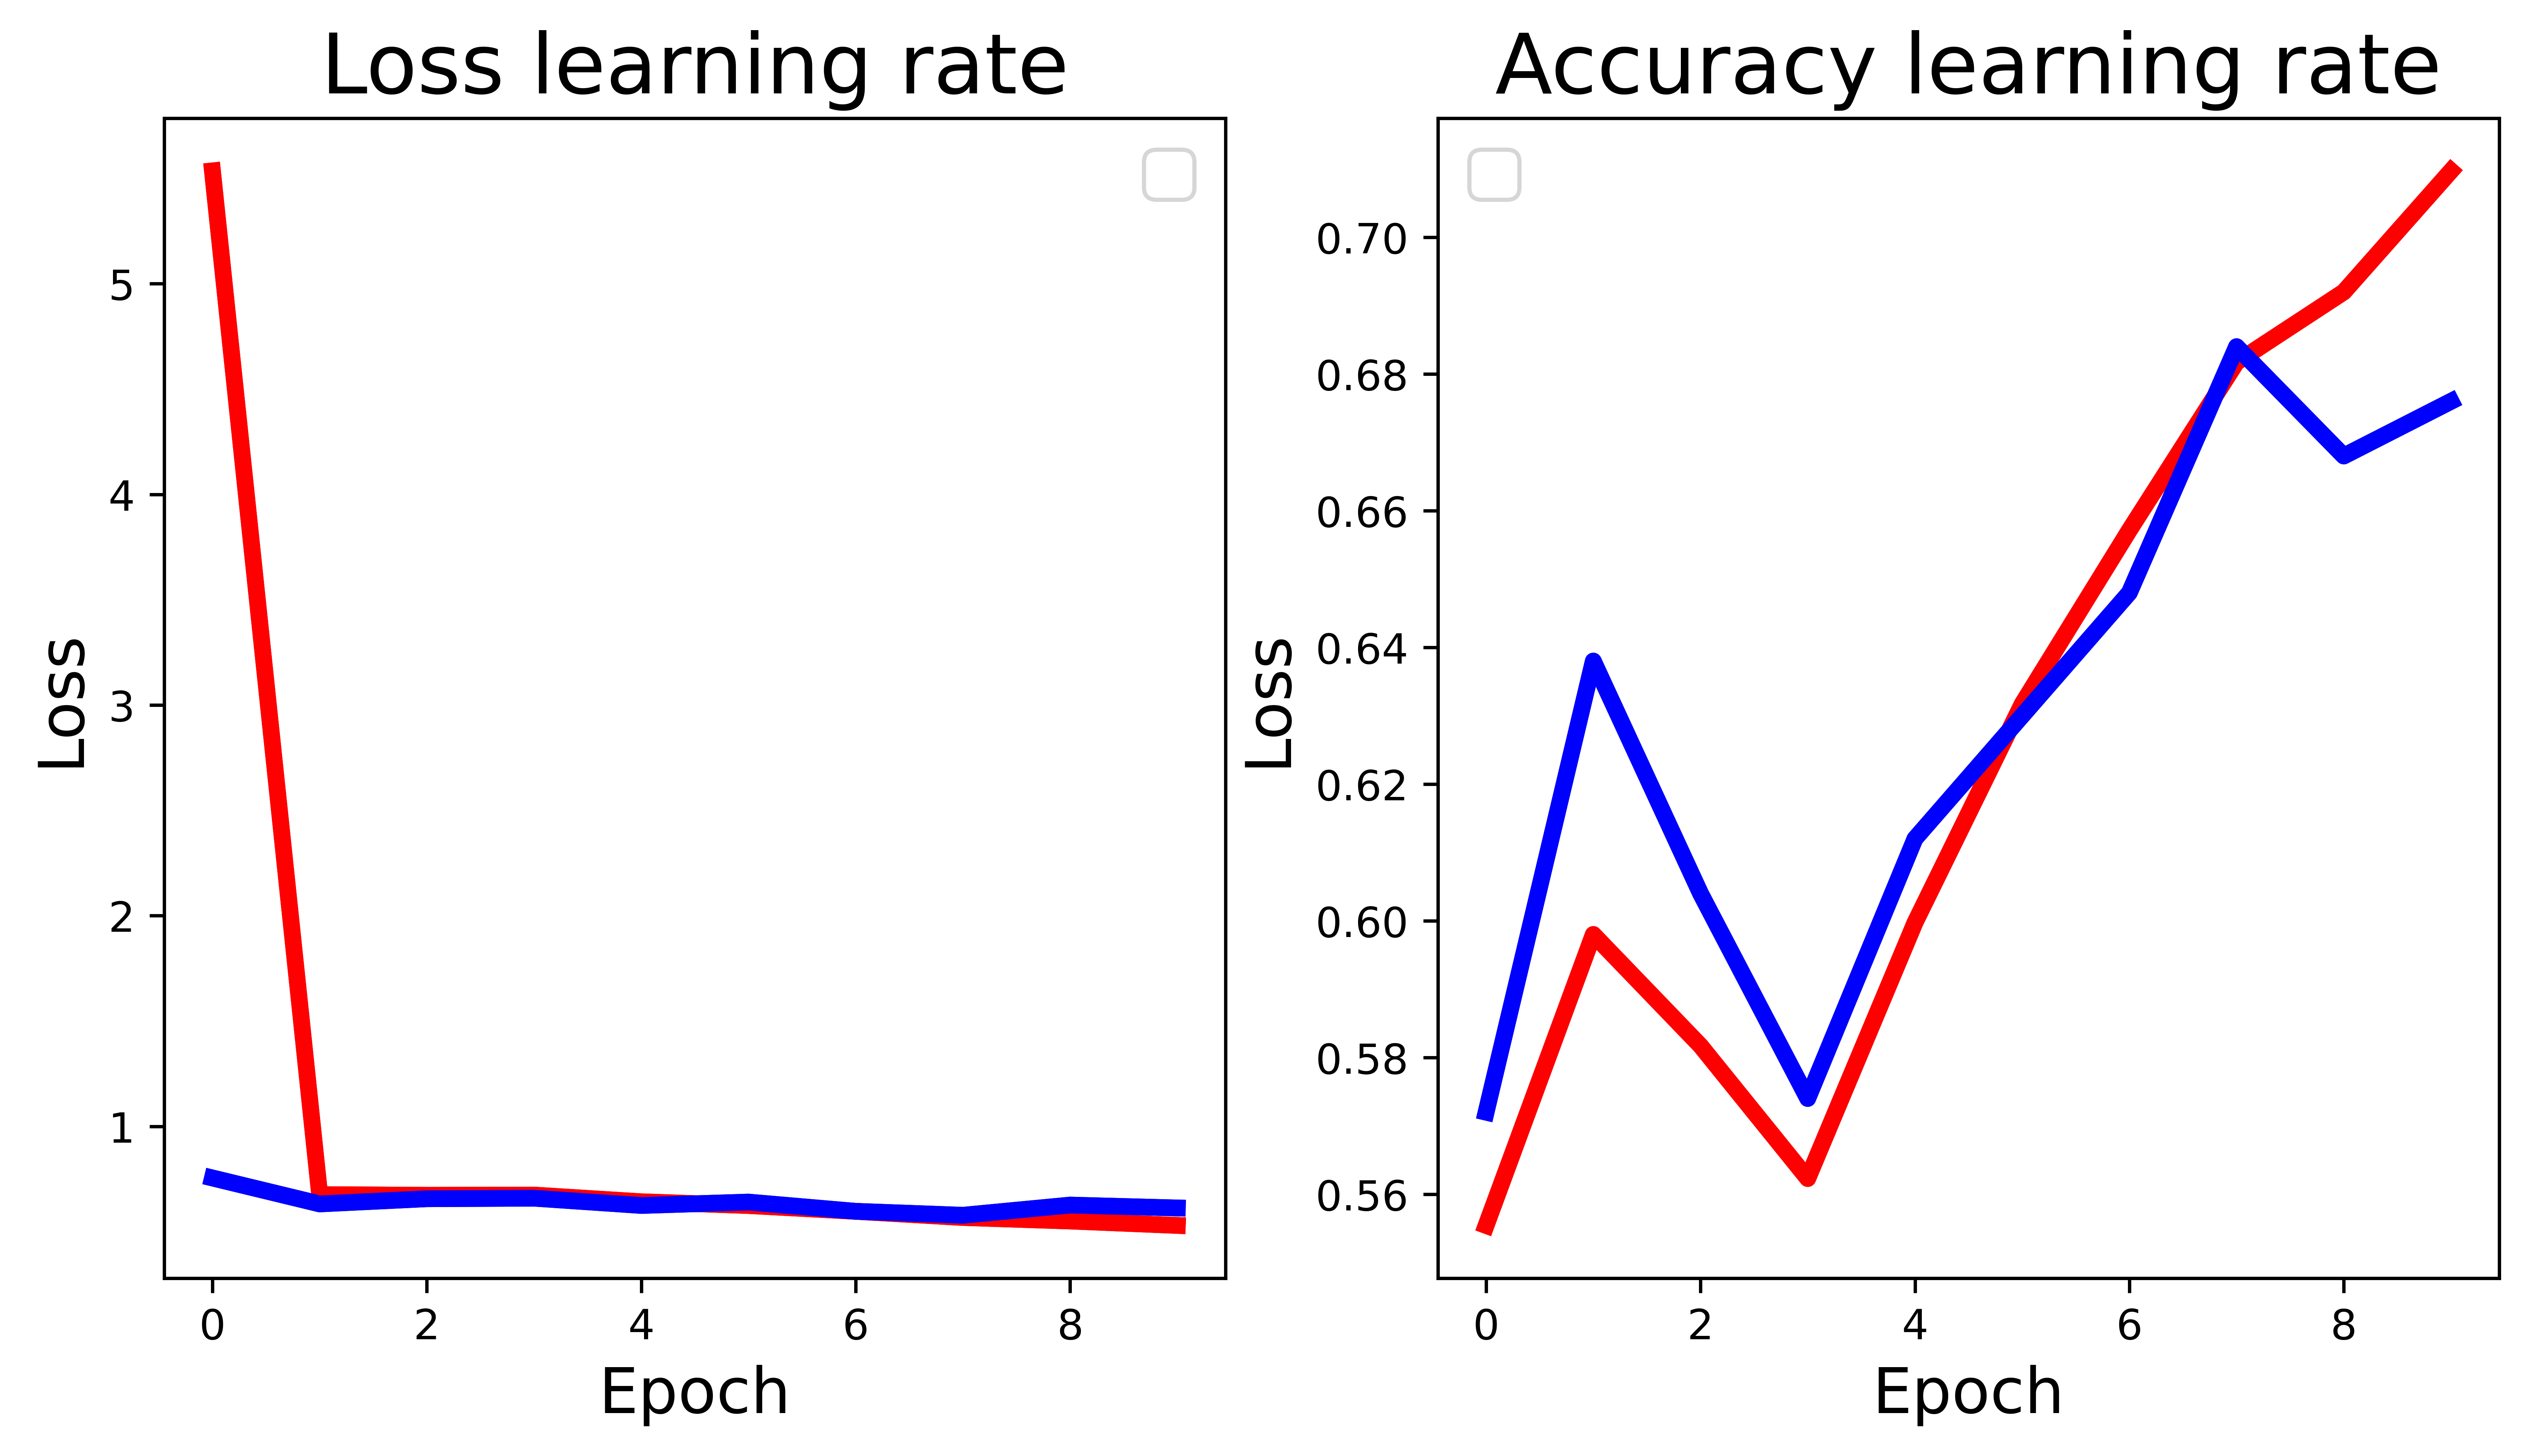

In [13]:
lr_graph(CNN_history)

### 3.1.4 Model evaluation and prediction

In [14]:
#Evaluate model on the test dataset
test_loss, test_acc = CNN_model.evaluate(X_test, y_test)
print('\nTest accuracy:', test_acc)

32/32 [==============================] - 1s 22ms/step - loss: 0.7841 - accuracy: 0.6790

Test accuracy: 0.6790000200271606


In [15]:
y_cnn_pre = CNN_model.predict(X_test)

32/32 [==============================] - 1s 14ms/step


In [16]:
#Get the most possible classification label by selecting the largest
cnn_predict_label = np.argmax(y_cnn_pre, axis=1)

In [17]:
report1 = classification_report(y_test, cnn_predict_label)
print(report1)

              precision    recall  f1-score   support

           0       0.63      0.83      0.72       494
           1       0.76      0.54      0.63       506

    accuracy                           0.68      1000
   macro avg       0.70      0.68      0.67      1000
weighted avg       0.70      0.68      0.67      1000



## 3.2 Pre-trained model

### 3.2.1 Model Building

In [18]:
# Initialize a ResNet50 model pre-trained on the ImageNet dataset.
# The final fully connected layer of the model which is responsible for classification is not included.
# The input shape for our model is set to 224x224 pixels with 3 color channels (RGB).
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Use the pre-trained weights of ResNet50 and avoid updating these layers during training
for layer in base_model.layers[:171]:
  layer.trainable = False

# Initialize a linear stack of layers. The first layer is base_model (ResNet50).
resNet_model = Sequential()
resNet_model.add(base_model)

# Flatten the output of the base_model into a single dimension.
# Because the subsequent dense layers require a flattened input, so we convert the output of the base model into a flat representation.
resNet_model.add(Flatten())

# Learn more complex patterns and representations based on the extracted features.
resNet_model.add(Dense(1024, activation='relu'))

# Dropout layer prevents overfitting
# It randomly sets a portion of the inputs to 0 during training, reducing over-reliance on specific features and preventing overfitting.
resNet_model.add(Dropout(0.5))

# Add a fully connected layer (output layer) with one output unit and a sigmoid activation function.
# The sigmoid activation function is for binary classification, the output is the probability of the input belonging to the positive class.
resNet_model.add(Dense(1, activation='sigmoid'))

# Compile the model with the specified loss function, optimizer, and metrics.
resNet_model.compile(optimizer=Adam(learning_rate=1e-5), loss='binary_crossentropy', metrics=['accuracy'])

resNet_model.summary()

94765736/94765736 [==============================] - 4s 0us/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten_1 (Flatten)         (None, 100352)            0         
                                                                 
 dense_2 (Dense)             (None, 1024)              102761472 
                                                                 
 dropout_4 (Dropout)         (None, 1024)              0         
                                                                 
 dense_3 (Dense)             (None, 1)                 1025      
                                                                 
Total params: 126,350,209
Trainable params: 103,817,217
Non-trainable params: 22,532,992
________________________________

- optimizer=Adam(le-5): The optimizer is the algorithm used to update the weights of the neural network to minimize the loss function. Adam is a popular choice because it combines the advantages of two other extensions of stochastic gradient descent: AdaGrad and RMSProp. The learning rate le-5 is a hyperparameter that controls how much to change the model in response to the estimated error each time the model weights are updated. Choosing the learning rate is challenging as a value too small may result in a long training process that could get stuck, whereas a value too large may result in learning a sub-optimal set of weights too fast or an unstable training process.

- loss='binary_crossentropy': The loss function is used to measure how well the model did on training. For binary classification problems, 'binary_crossentropy' is a common choice. It calculates the cross-entropy loss between true labels and predicted labels.

- metrics=['accuracy']: Metrics are used to monitor the training and testing steps. 'accuracy' is a common choice for classification problems. It calculates the proportion of correct predictions over all predictions.

### 3.2.2 Model training and fitting

In [19]:
# Train the model for 5 epochs on the training data (X_train, y_train).
# The validation_data argument is set to use the validation dataset to evaluate the model after each epoch.
# The batch_size argument specifies that 128 samples are used in one update of the model weights.
ResNet50_his = resNet_model.fit(X_train,
                    y_train,
                    validation_data=(X_val, y_val),
                    epochs=5,
                    batch_size=32)

Epoch 1/5
110/110 [==============================] - 28s 190ms/step - loss: 0.1872 - accuracy: 0.9426 - val_loss: 0.0618 - val_accuracy: 0.9760
Epoch 2/5
110/110 [==============================] - 17s 155ms/step - loss: 0.0173 - accuracy: 0.9937 - val_loss: 0.0826 - val_accuracy: 0.9760
Epoch 3/5
110/110 [==============================] - 15s 140ms/step - loss: 0.0114 - accuracy: 0.9969 - val_loss: 0.0933 - val_accuracy: 0.9700
Epoch 4/5
110/110 [==============================] - 16s 145ms/step - loss: 0.0054 - accuracy: 0.9969 - val_loss: 0.0987 - val_accuracy: 0.9720
Epoch 5/5
110/110 [==============================] - 15s 137ms/step - loss: 0.0055 - accuracy: 0.9977 - val_loss: 0.0921 - val_accuracy: 0.9780


### 3.2.3 Learning curve

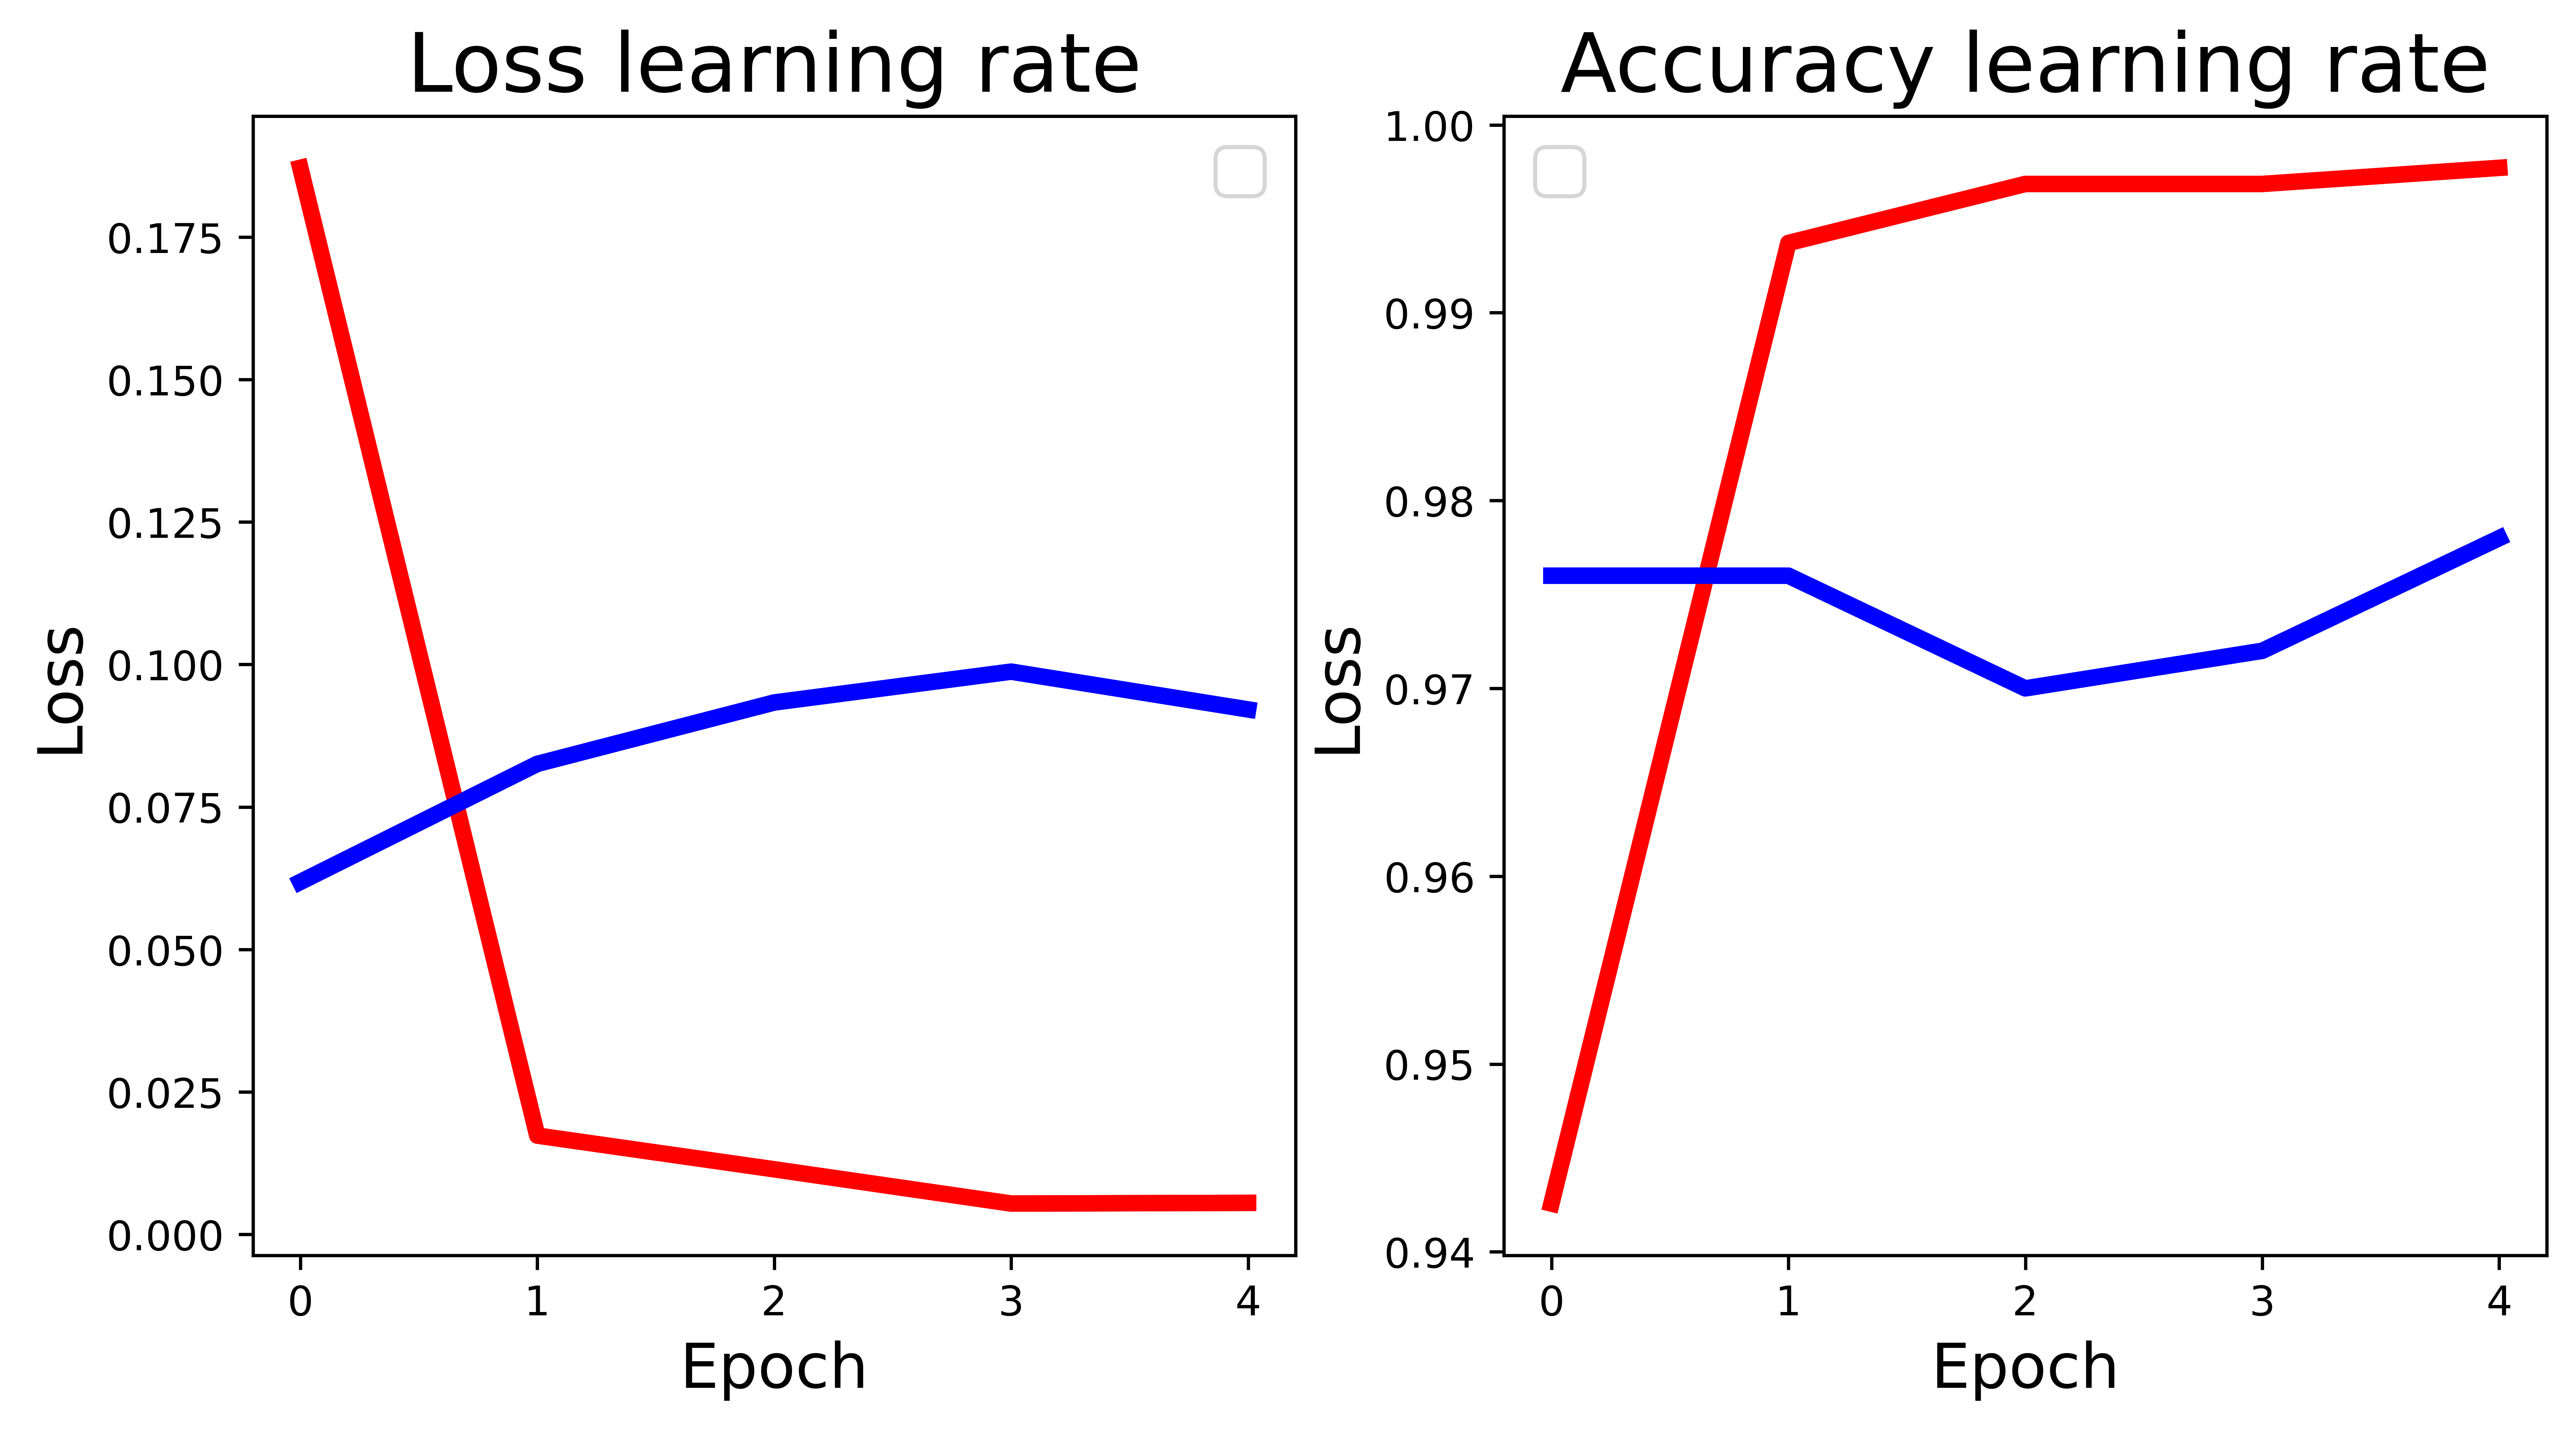

In [20]:
# Call the function to draw learning curve
lr_graph(ResNet50_his)

### 3.2.4 Model evaluation and prediction

In [21]:
# Evaluate the model on the test data (X_test, y_test) and print the accuracy of the model on this data.

test_loss, test_acc = resNet_model.evaluate(X_test, y_test)
print('\nTest accuracy:', test_acc)

32/32 [==============================] - 4s 129ms/step - loss: 0.1121 - accuracy: 0.9750

Test accuracy: 0.9750000238418579


In [22]:
y_resNet_pre = resNet_model.predict(X_test)
res_predict_label = (y_resNet_pre > 0.5).astype(int).flatten()
res_predict_label

32/32 [==============================] - 5s 103ms/step


array([1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1,
       0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1,
       1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1,
       1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0,
       0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1,
       0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1,
       0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0,
       1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0,
       1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1,
       0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1,

*resNet_model.predict* function returns the predicted probabilities because we use a sigmoid activation function in the output layer. Here we translate the probability into the binary label.

In [23]:
report2 = classification_report(y_test, res_predict_label)
print(report2)

              precision    recall  f1-score   support

           0       0.97      0.98      0.97       494
           1       0.98      0.97      0.98       506

    accuracy                           0.97      1000
   macro avg       0.97      0.98      0.97      1000
weighted avg       0.98      0.97      0.98      1000



#4.Model Comparison and Evaluation

## 4.1 Model comparison

In [27]:
print('Here are the classification reports for CNN and pre-trained models:\n')
print(f'CNN model: \n', report1)
print(f'pre-trained model: \n', report2)

Here are the classification reports for CNN and pre-trained models:

CNN model: 
               precision    recall  f1-score   support

           0       0.63      0.83      0.72       494
           1       0.76      0.54      0.63       506

    accuracy                           0.68      1000
   macro avg       0.70      0.68      0.67      1000
weighted avg       0.70      0.68      0.67      1000

pre-trained model: 
               precision    recall  f1-score   support

           0       0.97      0.98      0.97       494
           1       0.98      0.97      0.98       506

    accuracy                           0.97      1000
   macro avg       0.97      0.98      0.97      1000
weighted avg       0.98      0.97      0.98      1000



After comparison, we can clearly find out that **pre-trained model** worked **much better** than the **self-build CNN model**.

## 4.2 Model Evaluation

In [24]:
#Encode the prediction into numerical labels - 1 for dog, 0 for cat.
cnn_result = np.where(cnn_predict_label == 1, "Dog", "Cat")
res_result = np.where(res_predict_label == 1, "Dog", "Cat")

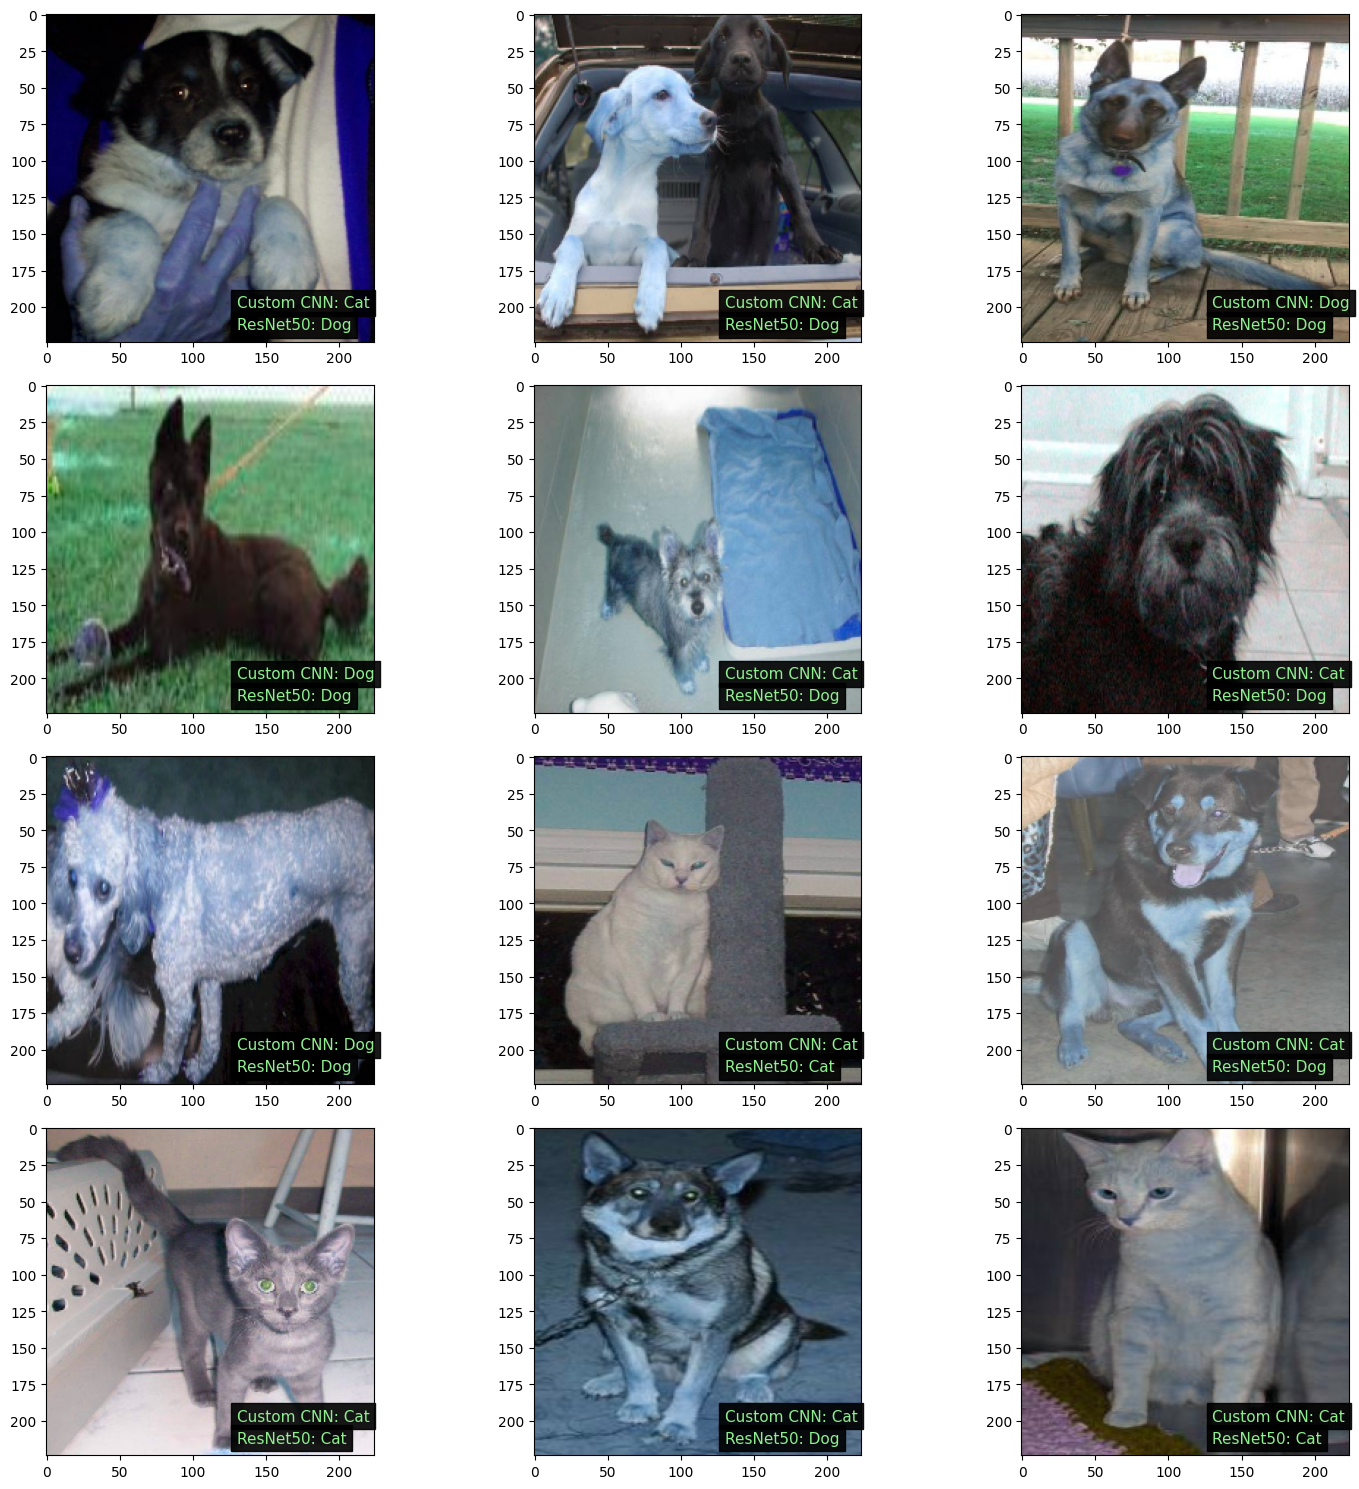

In [25]:
from PIL import Image
# plotting images with prediction label
pred_results  = list(zip(cnn_result,res_result))

plt.figure(figsize=(15, 15))
for i in range(0, 12):
    plt.subplot(4, 3, i+1)
    cust,ft = pred_results[i]
    img = X_test[i]
    image = Image.fromarray(img)
    plt.text(130, 200, 'Custom CNN: {}'.format(cust), color='lightgreen',fontsize= 11, bbox=dict(facecolor='black', alpha=0.9))
    plt.text(130, 215, 'ResNet50: {}'.format(ft), color='lightgreen',fontsize= 11, bbox=dict(facecolor='black', alpha=0.9))
    plt.imshow(image)

plt.tight_layout()
plt.show()

According to the prediction: we can clearly see that **both CNN and ResNet50** performs perfect on recognising cats. However, **CNN is not good at classify dogs** while ResNet50 pre-trained model did this job accurately.

# Model Test

Enter the image URL: https://hips.hearstapps.com/hmg-prod/images/dog-puppy-on-garden-royalty-free-image-1586966191.jpg?crop=0.752xw:1.00xh;0.175xw,0&resize=1200:*


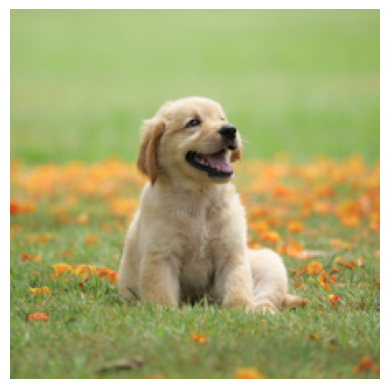

1/1 [==============================] - 1s 545ms/step
CNN_Predicted: True
res_Predicted: True


In [26]:
import requests
from io import BytesIO

# Read image from the url
image_url = input("Enter the image URL: ")
response = requests.get(image_url)
image = Image.open(BytesIO(response.content))

# Resize the image to the same size as the model's input
image = image.resize((224, 224))

image_array = np.array(image)

image_input = np.expand_dims(image_array, axis=0)

plt.imshow(image)
plt.axis("off")
plt.show()

# Predict the result using two models
CNN_prediction = CNN_model.predict(image_input)
res_prediction = resNet_model.predict(image_input)

# Print True if there's a dog in the picture, otherwise print False
CNN_predicted = True if np.argmax(CNN_prediction) == 1 else False
res_predicted = True if res_prediction > 0.5 else False

print("CNN_Predicted:", CNN_predicted)
print("res_Predicted:", res_predicted)


We chose a image of a dog randomly on the Internet, and we can see that **both algorithms** identified it correctly.

## Reference

1. [Feature Extractor & Fine-tuning with Keras](https://www.kaggle.com/code/angqx95/feature-extractor-fine-tuning-with-keras)
2. [Hey Siri!! is it a 🐱 or🐶 !! 🎯 Class-f1 (0.992)](https://www.kaggle.com/code/bhuvanchennoju/hey-siri-is-it-a-or-class-f1-0-992)
3. [Difference between Conv1D and Conv2D](https://renzibei.com/2020/06/30/conv1d%E4%B8%8Econv2d%E7%9A%84%E5%8C%BA%E5%88%AB/)